In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
hs_2028_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_files\\pu_with_proj_SPLIT.geojson').to_crs(epsg=3857)
hs_2028_geo.head(2)

,pu_2324_84,student_gen,basez,final_proj,geometry
0,1,0,0.0,0.0,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,0,4.0,4.0,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."


In [7]:
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Durham School of the Arts','Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs = dps_base_hs[['name','geometry']]
dps_base_hs.loc[6,'name']='New High School'
dps_base_hs = dps_base_hs.reset_index()

In [6]:
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_Files\\pu_2324_SPLIT.geojson').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu.head()

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
0,1,1,2.049028e+06,893128.606346,0.0,589,589,1,1,PU589,North,26532.120021,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,2,2.039923e+06,835434.121317,0.0,401,401,2,2,PU401,North,19333.085511,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."
2,3,3,2.058005e+06,797649.028742,0.0,782,782.0,3,3,PU782.0,East,18314.823119,1.329077e+07,"POLYGON ((-8.77e+06 4.29e+06, -8.77e+06 4.29e+..."
3,4,4,2.003222e+06,772895.737307,0.0,201,201.0,4,4,PU201.0,Southwest,29282.100083,4.684140e+07,"POLYGON ((-8.79e+06 4.29e+06, -8.79e+06 4.29e+..."
4,5,5,2.067334e+06,828244.230730,0.0,646,646,6,6,PU646,East,60685.151474,1.497046e+08,"POLYGON ((-8.77e+06 4.3e+06, -8.77e+06 4.3e+06..."


In [14]:
def score_candidate(candidate):
    school_names = ['Durham School of the Arts','Southern High School','Hillside High School','Northern High School','Riverside High School','Jordan High School','New High School']
    capacities = [800,1300,1200,1100,1100,1210,1300]

    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0,0],
                           'coefficient':[1,1,1,1,1,1,1]
                            })                               #initialize counts dataframe

    
    candidate_geom = candidate['geometry']
    dps_base_hs.loc[6,'geometry']=candidate_geom.centroid
    

    for i in range(30):                                      #iterative boundary assignment (running 30x)
        assignments = []
        for pu in hs_2028_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(7):                               #6 existing schools and 1 new
                dist = centroid.distance(dps_base_hs.loc[j,'geometry'])
                score = dist * counts.loc[j,'coefficient']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)                        #collect hs assignments based on min distance score
        hs_2028_geo['assign'] = assignments

        for i,school in enumerate(school_names):
            assigned_students = hs_2028_geo.loc[hs_2028_geo['assign'] == school, 'final_proj'].sum()
            counts.loc[i, 'count'] = assigned_students                    #sum up counts for all high schools and update coefficients
        counts['coefficient'] *= (counts['count']/counts['capacity'])**0.1

    objective=hs_2028_geo.merge(dps_base_hs,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = (objective['final_proj']*objective['distance']).sum()/(10**7)

    return objective_score,counts

candidate = dps_pu.loc[516]
score_candidate(candidate)

(2.434707059446526,
                       school  capacity  count  coefficient
 0  Durham School of the Arts       800    686     1.071702
 1       Southern High School      1300   1126     0.529205
 2       Hillside High School      1200   1087     0.781557
 3       Northern High School      1100    957     0.697280
 4      Riverside High School      1100    977     0.533071
 5         Jordan High School      1210   1092     0.806034
 6            New High School      1300   1090     0.469920)

<Axes: title={'center': 'Expanded HS Boundaries'}>

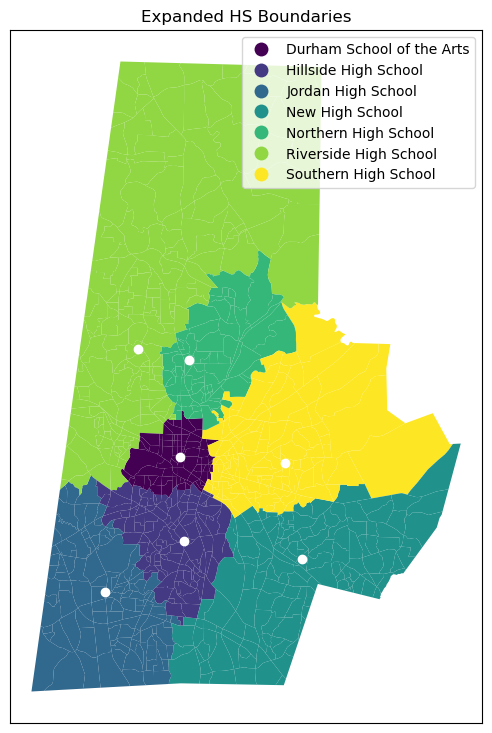

In [15]:
fig,ax = plt.subplots(figsize = (7,9))

hs_2028_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Expanded HS Boundaries')
dps_base_hs.plot(ax=plt.gca(), color = 'white')

In [30]:
single_reg = dps_base[~dps_base['region_base'].isin(['district-wide','regional (SW, SE, C)'])]
dps_base_ms = single_reg[single_reg['name'].str.contains('Middle School')]
dps_base_ms

,OBJECTID,facilityid,sch_id6,sch_id,name,address,phone,agencyurl,operhours,spectype,...,region_base,region_physical,calendar_2324,calendar_2425,choice_2324,choice_2425,choice_2526,x_ncplane,y_ncplane,geometry
13,14,63011,320338,338,Shepard Middle School,2401 Dakota Street Durham NC 27707,919-560-3938,http://shepard.dpsnc.net/pages/Shepard,8:30am - 3:20pm,Magnet School,...,southeast,southeast,Traditional,Traditional,International Baccalaureate,International Baccalaureate,International Baccalaureate,2029622.48,806279.92,POINT (-8.78e+06 4.3e+06)
18,19,55449,320342,342,Lakewood Montessori Middle School,2119 Chapel Hill Rd Durham NC 27707,919-560-2894,http://montessorimiddle.dpsnc.net/pages/Lakewo...,8:30am - 3:20pm,Magnet School,...,southwest,southwest,Traditional,Traditional,Montessori,Montessori,Montessori,2021065.11,813369.45,POINT (-8.79e+06 4.3e+06)
20,21,40745,320355,355,Neal Middle School,201 Baptist Road Durham NC 27704,919-560-3955,http://neal.dpsnc.net/pages/Neal_Middle,8:30am - 3:20pm,Magnet School,...,east,east,Traditional,Traditional,STEM,STEM,None,2064533.05,810848.61,POINT (-8.77e+06 4.3e+06)
21,22,80722,320346,346,Lowes Grove Middle School,4418 South Alston Avenue Durham NC 27713,919-560-3946,http://lowesgrove.dpsnc.net/pages/Lowes_Grove_...,8:30am - 3:20pm,Magnet School,...,southeast,southeast,Traditional,Traditional,STEM,STEM,None,2032340.27,784223.19,POINT (-8.78e+06 4.29e+06)
46,47,130124,320306,306,Brogden Middle School,1001 Leon Street Durham NC 27704,919-560-3906,http://www.edlinesites.net/pages/Brogden_Middle,8:30am - 3:20pm,None,...,central,central,Traditional,Traditional,None,None,Dual Language Instruction,2026821.01,827899.40,POINT (-8.78e+06 4.3e+06)
47,48,22949,320316,316,Carrington Middle School,227 Milton Road Durham NC 27712,919-560-3916,http://www.edlinesites.net/pages/Carrington_Mi...,8:30am - 3:20pm,None,...,north,north,Traditional,Traditional,None,None,None,2024318.17,850685.19,POINT (-8.79e+06 4.31e+06)
49,50,97206,320343,343,Lucas Middle School,923 Snow Hill Rd Durham NC 27712,919-560-3843,http://www.edlinesites.net/pages/Lucas_Middle,8:30am - 3:20pm,None,...,north,north,Traditional,Traditional,None,None,Montessori,2033617.13,858740.70,POINT (-8.78e+06 4.32e+06)
50,51,68940,320366,366,Githens Middle School,4800 Old Chapel Hill Road Durham NC 27707,919-560-3966,http://www.edlinesites.net/pages/Githens_Middle,8:30am - 3:20pm,None,...,southwest,southwest,Traditional,Traditional,None,None,None,2005684.95,798729.31,POINT (-8.79e+06 4.29e+06)
